In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline
import time

In [2]:
with np.load('/content/drive/MyDrive/Colab Notebooks/prediction-challenge-02-data.npz') as fh:
    x_train = fh['x_train']
    y_train = fh['y_train']
    x_test = fh['x_test']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER (6000)
# 2/3. INDEX: PIXEL VALUE (32 x 32)
# 4. INDEX: COLOR CHANNELS (3)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)

# TEST DATA: INPUT (x) ONLY
print(x_test.shape, x_test.dtype)

(3000, 32, 32, 3) float32
(3000,) float64
(300, 32, 32, 3) float32


In [3]:
x_train = np.transpose(x_train, axes=[0, 3, 1, 2])
x_test = np.transpose(x_test, axes=[0, 3, 1, 2])
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_test.shape, x_test.dtype)

(3000, 3, 32, 32) float32
(3000,) float64
(300, 3, 32, 32) float32


In [4]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'truck', 'ship')

In [5]:
LR = 0.001 
EPOCH = 30
BATCH_SIZE = 32

In [6]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [7]:
# Transform np to tensor
torch_X_train = torch.tensor(X_train)
torch_y_train = torch.tensor(y_train)

torch_X_val = torch.tensor(X_val)
torch_y_val = torch.tensor(y_val)

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
validate = torch.utils.data.TensorDataset(torch_X_val,torch_y_val)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
val_loader = torch.utils.data.DataLoader(validate, batch_size = BATCH_SIZE, shuffle = False)

In [8]:
train_batch_size = 100
test_batch_size = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

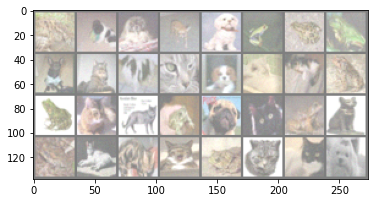

 bird   car   car   car   car  bird  bird  bird   car plane   car plane   car plane plane  bird  bird plane plane  bird   car plane  bird plane  bird plane plane plane  bird plane plane   car


In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j].to(dtype=torch.long, device=device)] for j in range(32)))

In [10]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv_layer = nn.Sequential(

      # Conv Layer block 1
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # Conv Layer block 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=0.05),

      # Conv Layer block 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )


    self.fc_layer = nn.Sequential(
      nn.Dropout(p=0.1),
      nn.Linear(4096, 1024),
      nn.ReLU(inplace=True),
      nn.Linear(1024, 512),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      nn.Linear(512, 10)
    )

  def forward(self, x):
    # conv layers
    x = self.conv_layer(x)
    
    # flatten
    x = x.view(x.size(0), -1)
    
    # fc layer
    x = self.fc_layer(x)
    return x

In [11]:
cnn = CNN()

In [12]:
cnn.to(device)

loss_func = torch.nn.CrossEntropyLoss() 
optimizer = optim.Adam(cnn.parameters(), lr=LR)

In [13]:
cnn.train()   
state_dicts = {}

train_loss = np.zeros(EPOCH)
val_loss = np.zeros(EPOCH)

for epoch in range(EPOCH):  
  for data in train_loader:    
    X, y = data
    cnn.zero_grad()                     
    output = cnn(X.to(device))                    
    y = torch.tensor(y, dtype=torch.int64).cuda()
    loss = loss_func(output, y)        
    loss.backward()                     
    optimizer.step()                    
    train_loss[epoch] += loss
  # normalizing the loss by the total number of train batches  
  train_loss[epoch] /= len(train_loader)  

  with torch.no_grad():
    for X, y in val_loader:
      output = cnn(X.to(device))
      y = torch.tensor(y, dtype=torch.int64).cuda()
      
      loss = loss_func(output, y) 
      val_loss[epoch] += loss
    val_loss[epoch] /= len(val_loader)

  state_dicts[epoch] = cnn.state_dict()   

  print('epoch %d:\ttrain loss: %.5f\tvalidation loss: %.5f'%(epoch, train_loss[epoch], val_loss[epoch])) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0:	train loss: 1.11193	validation loss: 0.89427
epoch 1:	train loss: 0.85057	validation loss: 0.80022
epoch 2:	train loss: 0.79533	validation loss: 0.74824
epoch 3:	train loss: 0.77807	validation loss: 0.74779
epoch 4:	train loss: 0.73314	validation loss: 0.75517
epoch 5:	train loss: 0.70341	validation loss: 0.74348
epoch 6:	train loss: 0.66522	validation loss: 0.71027
epoch 7:	train loss: 0.63123	validation loss: 0.66764
epoch 8:	train loss: 0.58960	validation loss: 0.69164
epoch 9:	train loss: 0.60050	validation loss: 0.72256
epoch 10:	train loss: 0.51912	validation loss: 0.77681
epoch 11:	train loss: 0.48815	validation loss: 0.77865
epoch 12:	train loss: 0.46890	validation loss: 0.82598
epoch 13:	train loss: 0.41462	validation loss: 0.76422
epoch 14:	train loss: 0.39843	validation loss: 0.84519
epoch 15:	train loss: 0.33344	validation loss: 0.81488
epoch 16:	train loss: 0.28483	validation loss: 0.96957
epoch 17:	train loss: 0.29094	validation loss: 0.90185
epoch 18:	train loss

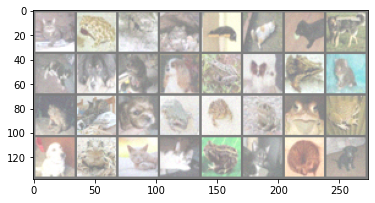

GroundTruth:  plane  bird plane  bird plane plane   car   car plane   car plane   car  bird   car  bird plane  bird plane   car  bird  bird  bird  bird  bird   car  bird plane plane  bird plane plane   car


In [14]:
dataiter = iter(val_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].to(dtype=torch.long, device=device)] for j in range(32)))

In [15]:
cnn.cpu().eval()

output_train = cnn(torch_X_train.cpu()).cpu().detach().numpy().argmax(axis=1)
output_val = cnn(torch_X_val.cpu()).cpu().detach().numpy().argmax(axis=1)

print('Training accuracy:\t%.3f'%(sum(output_train == y_train)/len(y_train)))
print('Validation accuracy:\t%.3f'%(sum(output_val == y_val)/len(y_val)))

Training accuracy:	0.991
Validation accuracy:	0.710


In [16]:
prediction = cnn(torch.from_numpy(x_test)).cpu().detach().numpy().argmax(axis=1)

In [17]:
print(prediction[19])

0


In [18]:
assert prediction.ndim == 1
assert prediction.shape[0] == 300

In [19]:
np.save('prediction.npy', prediction.astype(int))